In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import keras
import seaborn as sns
import pathlib
from pathlib import Path
import glob
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils  import to_categorical
# Import ImageDataGenerator from tensorflow.keras.preprocessing.image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
data_dir='/content/drive/MyDrive/Colab Notebooks/chest_xray'
root_dir='/kaggle/working/'
def countfiles(root_dir):
    for path in pathlib.Path(root_dir).iterdir():
        if path.is_dir():
             print( str(len([name for name in os.listdir(path) \
            if os.path.isfile(os.path.join(path, name))])) + " files inside the " + \
            str(path.name),'class')
countfiles(data_dir)

4273 files inside the Pneumonia class
1583 files inside the Normal class


In [ ]:
def data_categories(d_path):
    categories=[]    #listdir-->used to get the list of all files and directories in the specified directory
    for folder_name in os.listdir(d_path):  #os.path.isdir()--->used to check whether the specified path is an existing directory or not.
        if os.path.isdir(os.path.join(d_path,folder_name)):
            no_of_files=len(glob.glob(os.path.join(d_path, folder_name)+"/*.jpeg"))
            categories.append(np.array([folder_name,no_of_files]))
    categories.sort(key=lambda a:a[0])
    cat=np.array(categories)
    return list(cat[:, 0]),list(cat[:,1])
categories,no_of_files = data_categories("/content/drive/MyDrive/Colab Notebooks/chest_xray")
print(categories)

[np.str_('Normal'), np.str_('Pneumonia')]


In [ ]:
import os
import glob
import numpy as np

def get_categories(data_path):
    categories = []

    for folder in os.listdir(data_path):
        folder_path = os.path.join(data_path, folder)

        if os.path.isdir(folder_path):
            image_files = glob.glob(os.path.join(folder_path, "*.jpeg"))
            categories.append([folder, len(image_files)])

    # Sort by folder name
    categories.sort(key=lambda x: x[0])

    # Separate names and counts
    category_names = [item[0] for item in categories]
    image_counts = [item[1] for item in categories]

    return category_names, image_counts

# Example usage
categories, no_of_files = get_categories("/content/drive/MyDrive/Colab Notebooks/chest_xray")
print("Categories:", categories)
print("Number of files:", no_of_files)


Categories: ['Normal', 'Pneumonia']
Number of files: [1583, 4273]


In [ ]:
print("number of categories: ", len(categories))

number of categories:  2


In [ ]:
df = pd.DataFrame({"category": categories, "number of files": no_of_files})
df

,category,number of files
0,Normal,1583
1,Pneumonia,4273


In [ ]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 5

In [ ]:


# Update the path to your dataset directory.
# If it's in your Google Drive, it might look like '/content/drive/MyDrive/dataset'
dataset_path = "/content/drive/MyDrive/Colab Notebooks/chest_xray"

# Manually count the images in each class directory
class_image_counts = {class_name: len(os.listdir(os.path.join(dataset_path, class_name)))
                      for class_name in os.listdir(dataset_path)
                      if os.path.isdir(os.path.join(dataset_path, class_name))}

print("Image counts per class:", class_image_counts)

# Assign the result of the function call to the variable 'dataset'
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,  # Use the correct path to your dataset
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)
num_batches = len(dataset)
print(f"Number of batches: {num_batches}")
total_images = 0
for batch in dataset:
    total_images += batch[0].shape[0]  # batch[0] are the images

print(f"Total number of images: {total_images}")

class_name = dataset.class_names # Now you can use 'dataset'
print(class_name)

# Number of images (approximation)
num_images = total_images
print(f"Approximate total number of images: {num_images}")

Image counts per class: {'Pneumonia': 4273, 'Normal': 1583}
Found 5856 files belonging to 2 classes.
Number of batches: 183
Total number of images: 5856
['Normal', 'Pneumonia']
Approximate total number of images: 5856


In [ ]:
for image_batch, labels_batch in dataset.take(1):
    pass

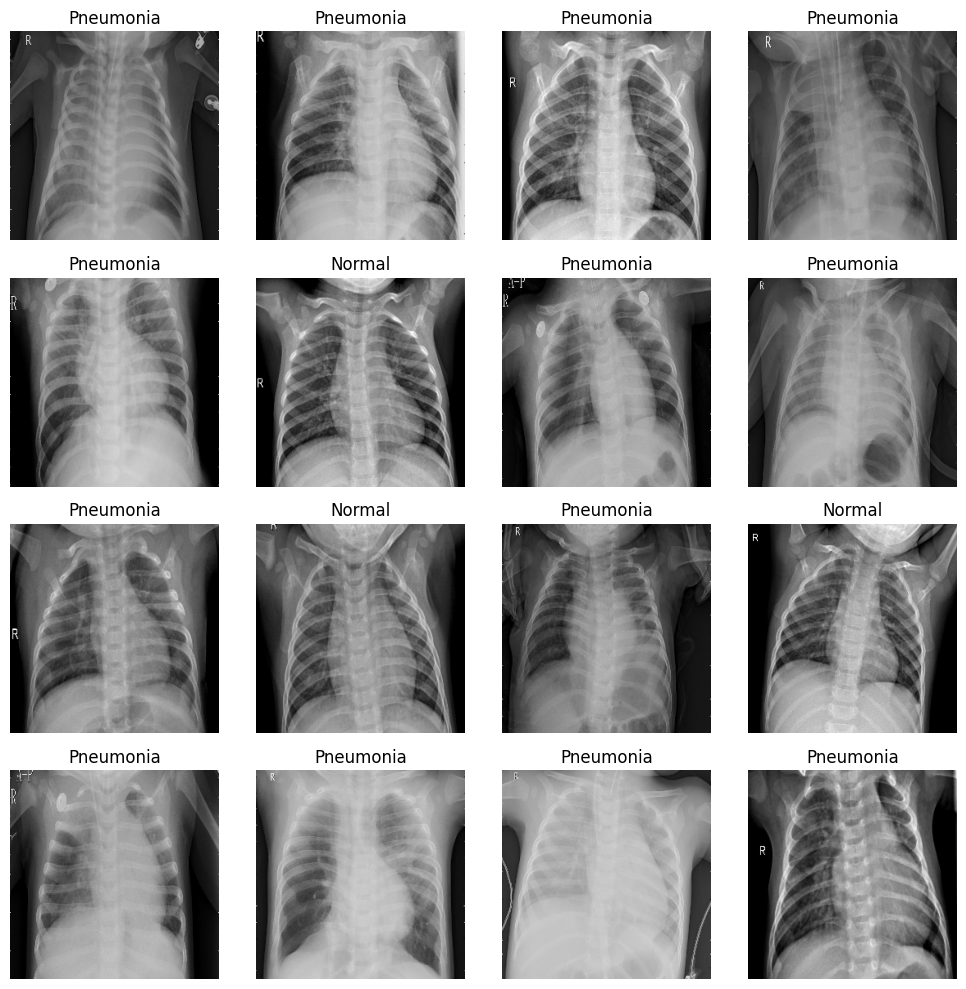

In [ ]:
for image_batch, labels_batch in dataset.take(1):
    plt.figure(figsize=(10, 10))  # Bigger figure
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)  # 4x4 grid
        plt.imshow(image_batch[i].numpy().astype("uint8"))  # Convert tensor to uint8 image
        plt.title(class_name[labels_batch[i].numpy()])  # Correct label name
        plt.axis("off")
    plt.tight_layout()
    plt.show()  # Show all 16 images at once


In [ ]:
def get_dataset_partitions_tf(ds, train_split= 0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):

  ds_size = len(ds)
  if shuffle:
    ds = ds.shuffle(shuffle_size, seed=12)

  train_size = int(train_split * ds_size)
  val_size = int(val_split * ds_size)

  train_ds = ds.take(train_size)

  val_ds = ds.skip(train_size).take(val_size)
  test_ds = ds.skip(train_size).skip(val_size)

  return train_ds, val_ds, test_ds


In [ ]:
# Call the get_dataset_partitions_tf function to create train_ds, val_ds, and test_ds
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

# Now you can print their lengths:
print(len(train_ds))
print(len(val_ds))


146
18


In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


resize_and_rescale = tf.keras.Sequential([
     layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
     layers.Rescaling(1.0/255)
])

In [ ]:
data_augmentation = tf.keras.Sequential([
     layers.RandomFlip("horizontal_and_vertical"),
     layers.RandomRotation(0.2),
])

In [ ]:
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.applications.densenet import *
from keras.applications.vgg16 import *
from keras.optimizers import *
from keras.layers import *
from keras.optimizers import Adam, SGD
from keras.models import Model, load_model
from keras.activations import *
import keras.backend as K, keras, numpy as np, cv2, tensorflow as tf, warnings
warnings.filterwarnings('ignore')

# Create a VGG-16 model
base_model = VGG16(weights=None,include_top=False, input_shape=(256,256,3))
y = Flatten()(base_model.output)
y = Dense(1024, activation = 'relu')(y)
y = Dropout(0.5)(y)
predictions = Dense(14, activation='sigmoid')(y)
# Use 'inputs' and 'outputs' instead of 'input' and 'output'
new_model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
new_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    33,555,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 14)             │        14,350 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,284,494 (184.19 MB)

 Trainable params: 48,284,494 (184.19 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Original (Problematic)
new_model.compile(optimizer=Adam(learning_rate=0.0003), loss='binary_crossentropy', metrics=['accuracy'])

# Changed (Fixed)
new_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0003),  # Or Adam(learning_rate=0.0003)
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
callback = EarlyStopping(
    monitor = 'val_loss',
    min_delta = 0.00001,
    patience = 20,
    baseline = None,
    verbose = 1,
    mode = "auto",
    restore_best_weights = False
)

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):

  ds_size = len(ds)
  if shuffle:
    ds = ds.shuffle(shuffle_size, seed=12)

  train_size = int(train_split * ds_size)
  val_size = int(val_split * ds_size)
  test_size = int(test_split * ds_size) # Add test_size calculation

  train_ds = ds.take(train_size)
  val_ds = ds.skip(train_size).take(val_size)
  test_ds = ds.skip(train_size + val_size).take(test_size) # Skip train and val for test

  return train_ds, val_ds, test_ds

In [ ]:
new_model.compile(optimizer=Adam(learning_rate=0.0003), loss='binary_crossentropy', metrics=['accuracy'])
#new_model.fit(train_data[:30000,], train_label[:30000,], validation_data = (train_data[30000:35000], train_label[30000:35000,]),epochs=15, batch_size=64)
#test_loss, test_accu = new_model.evaluate(train_data[55000:60000,], train_label[55000:60000,])
#print('Test Accuracy =', test_accu*100, '%')

In [ ]:
history = new_model.fit( # Change model to new_model
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS, # EPOCH is not defined , change it to EPOCHS
    callbacks=[callback]
)

Epoch 1/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 271s 1s/step - accuracy: 0.6508 - loss: 1.5445 - val_accuracy: 0.8924 - val_loss: 0.2758
Epoch 2/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 247s 964ms/step - accuracy: 0.8777 - loss: 0.2885 - val_accuracy: 0.9253 - val_loss: 0.2187
Epoch 3/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 193s 966ms/step - accuracy: 0.9185 - loss: 0.2072 - val_accuracy: 0.9462 - val_loss: 0.1528
Epoch 4/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 194s 963ms/step - accuracy: 0.9431 - loss: 0.1599 - val_accuracy: 0.9618 - val_loss: 0.1181
Epoch 5/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 219s 1s/step - accuracy: 0.9525 - loss: 0.1326 - val_accuracy: 0.9531 - val_loss: 0.1208


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


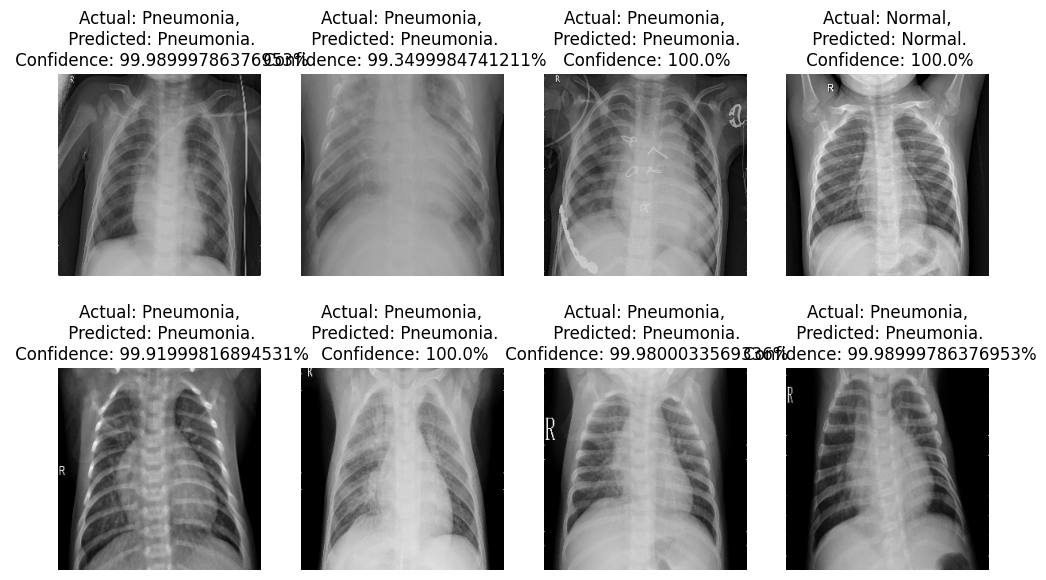

In [ ]:
import numpy as np

def predict(model, image, class_names):
  """
  Predicts the class of an image using the given model.

  Args:
    model: The Keras model to use for prediction.
    image: The image to predict the class for.
    class_names: A list of class names.

  Returns:
    A tuple containing the predicted class name and the confidence score.
  """
  img_array = np.expand_dims(image, axis=0)
  prediction = model.predict(img_array)
  predicted_class_index = np.argmax(prediction)
  confidence = round(100 * (np.max(prediction)), 2)  # Confidence in percentage
  predicted_class = class_names[predicted_class_index]
  return predicted_class, confidence

plt.figure(figsize=(12, 7))
for images, label in test_ds.take(1):
  for i in range(8):
    ax = plt.subplot(2, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))

    # Replace 'model' with 'new_model' or the correct model variable name
    predicted_class, confidence = predict(new_model, images[i].numpy(), class_name)
    actual_class = class_name[label[i]]

    plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

    plt.axis("off")

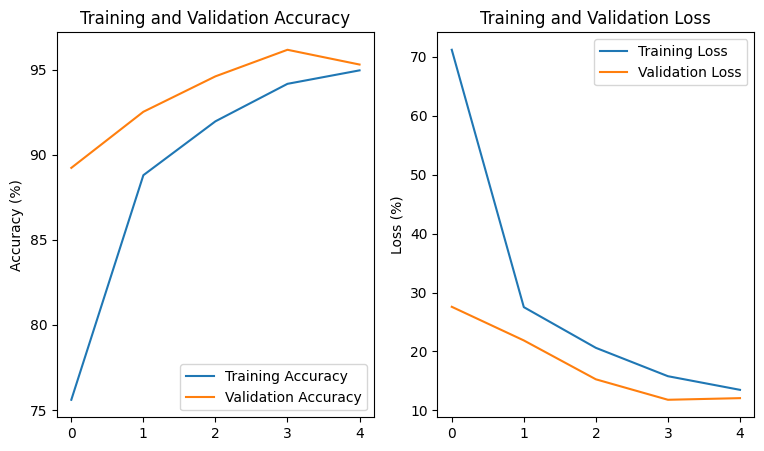

In [ ]:
plt.figure(figsize=(9, 5))

# Extract accuracy and loss from the history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# First Subplot: Accuracy (Scaled to 1-100)
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), [x * 100 for x in acc], label='Training Accuracy')  # Scale by 100
plt.plot(range(EPOCHS), [x * 100 for x in val_acc], label='Validation Accuracy')  # Scale by 100
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy (%)')  # Add ylabel to indicate percentage

# Second Subplot: Loss (Scaled to 1-100)
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), [x * 100 for x in loss], label='Training Loss')  # Scale by 100
plt.plot(range(EPOCHS), [x * 100 for x in val_loss], label='Validation Loss')  # Scale by 100
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel('Loss (%)')  # Add ylabel to indicate percentage

plt.show()

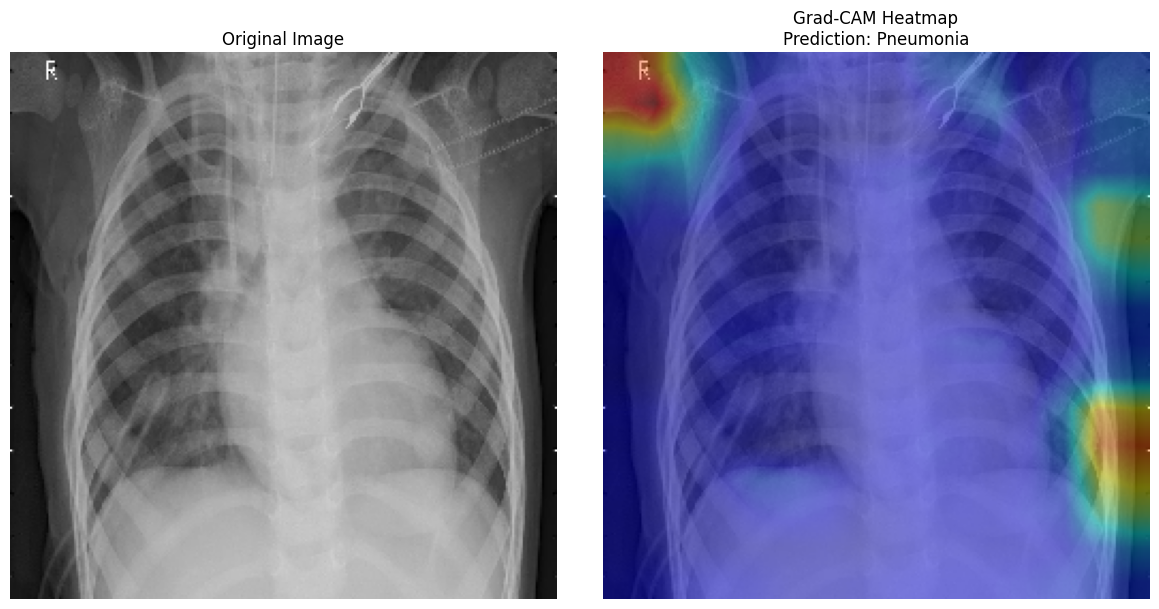

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.models import Model
from skimage.color import gray2rgb
from tensorflow.keras.preprocessing import image

# Define a function to process the image, apply Grad-CAM, and display results
def generate_grad_cam(image_path, model, class_labels=["Normal", "Pneumonia"], last_conv_layer_name="block5_conv3", target_size=(256, 256)):
    """
    Generate Grad-CAM heatmap for a given image.

    Parameters:
        image_path (str): Path to the image file.
        model (tf.keras.Model): Pretrained model.
        class_labels (list): List of class labels corresponding to the model's output classes.
        last_conv_layer_name (str): Name of the last convolutional layer for Grad-CAM.
        target_size (tuple): Resize image to this size before feeding to the model.
    """
    # Step 1: Load and preprocess the image
    img = image.load_img(image_path, target_size=target_size, color_mode='rgb')  # Load image
    img_array = image.img_to_array(img)  # Convert to array
    x = np.expand_dims(img_array, axis=0)  # Add batch dimension
    x = tf.cast(x, tf.float32)  # Ensure it's a float tensor

    # Step 2: Get predictions from the model
    preds = model(x)
    class_idx = tf.argmax(preds[0])  # Get the most likely predicted class
    predicted_class = class_labels[class_idx]  # Get the corresponding label for the predicted class

    # Step 3: Create a sub-model for Grad-CAM
    last_conv_layer = model.get_layer(last_conv_layer_name)  # Get the last convolutional layer
    grad_model = tf.keras.models.Model([model.inputs], [last_conv_layer.output, model.output])

    # Step 4: Record gradients using GradientTape
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(x)
        loss = predictions[:, class_idx]

    # Step 5: Compute gradients
    grads = tape.gradient(loss, conv_outputs)

    # Step 6: Compute the mean of the gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Step 7: Multiply each channel by its importance (gradient)
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Step 8: Normalize the heatmap
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    heatmap = heatmap.numpy()

    # Step 9: Resize heatmap to match the original image size
    heatmap_resized = cv2.resize(heatmap, (img_array.shape[1], img_array.shape[0]))
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)

    # Step 10: Overlay the heatmap on the original image
    superimposed_img = cv2.addWeighted(img_array.astype('uint8'), 0.6, heatmap_colored, 0.4, 0)

    # Step 11: Display the original image and Grad-CAM heatmap
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(img_array.astype('uint8'))
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(superimposed_img)
    plt.title(f"Grad-CAM Heatmap\nPrediction: {predicted_class}")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Example usage: Provide an image path and call the function
image_path = "/content/drive/MyDrive/Colab Notebooks/chest_xray/Pneumonia/BACTERIA-1025587-0001.jpeg"  # Change this to your image file path
generate_grad_cam(image_path, new_model)


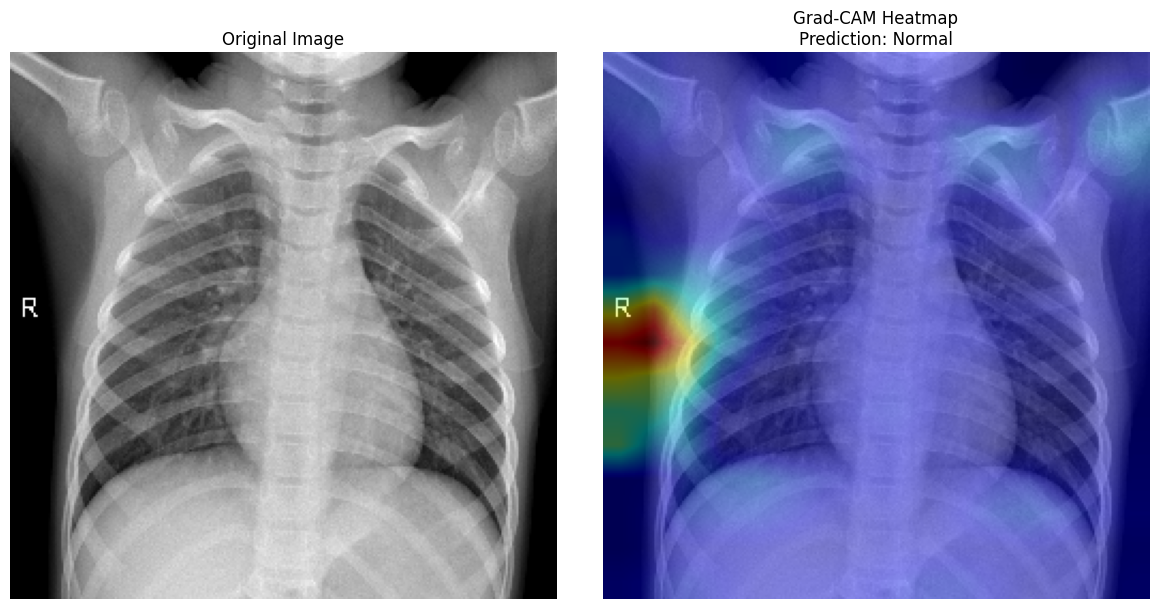

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.models import Model
from skimage.color import gray2rgb
from tensorflow.keras.preprocessing import image

# Define a function to process the image, apply Grad-CAM, and display results
def generate_grad_cam(image_path, model, class_labels=["Normal", "Pneumonia"], last_conv_layer_name="block5_conv3", target_size=(256, 256)):
    """
    Generate Grad-CAM heatmap for a given image.

    Parameters:
        image_path (str): Path to the image file.
        model (tf.keras.Model): Pretrained model.
        class_labels (list): List of class labels corresponding to the model's output classes.
        last_conv_layer_name (str): Name of the last convolutional layer for Grad-CAM.
        target_size (tuple): Resize image to this size before feeding to the model.
    """
    # Step 1: Load and preprocess the image
    img = image.load_img(image_path, target_size=target_size, color_mode='rgb')  # Load image
    img_array = image.img_to_array(img)  # Convert to array
    x = np.expand_dims(img_array, axis=0)  # Add batch dimension
    x = tf.cast(x, tf.float32)  # Ensure it's a float tensor

    # Step 2: Get predictions from the model
    preds = model(x)
    class_idx = tf.argmax(preds[0])  # Get the most likely predicted class
    predicted_class = class_labels[class_idx]  # Get the corresponding label for the predicted class

    # Step 3: Create a sub-model for Grad-CAM
    last_conv_layer = model.get_layer(last_conv_layer_name)  # Get the last convolutional layer
    grad_model = tf.keras.models.Model([model.inputs], [last_conv_layer.output, model.output])

    # Step 4: Record gradients using GradientTape
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(x)
        loss = predictions[:, class_idx]

    # Step 5: Compute gradients
    grads = tape.gradient(loss, conv_outputs)

    # Step 6: Compute the mean of the gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Step 7: Multiply each channel by its importance (gradient)
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Step 8: Normalize the heatmap
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    heatmap = heatmap.numpy()

    # Step 9: Resize heatmap to match the original image size
    heatmap_resized = cv2.resize(heatmap, (img_array.shape[1], img_array.shape[0]))
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)

    # Step 10: Overlay the heatmap on the original image
    superimposed_img = cv2.addWeighted(img_array.astype('uint8'), 0.6, heatmap_colored, 0.4, 0)

    # Step 11: Display the original image and Grad-CAM heatmap
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(img_array.astype('uint8'))
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(superimposed_img)
    plt.title(f"Grad-CAM Heatmap\nPrediction: {predicted_class}")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Example usage: Provide an image path and call the function
image_path = "/content/drive/MyDrive/Colab Notebooks/chest_xray/Normal/NORMAL-1012843-0001.jpeg"  # Change this to your image file path
generate_grad_cam(image_path, new_model)

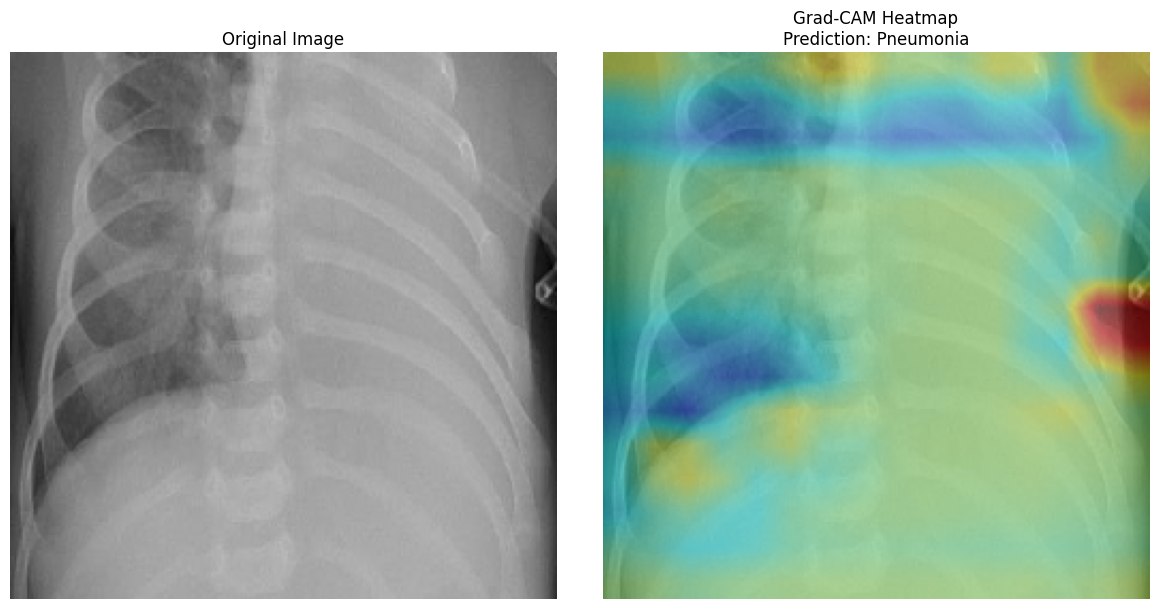

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.models import Model
from skimage.color import gray2rgb
from tensorflow.keras.preprocessing import image

# Define a function to process the image, apply Grad-CAM, and display results
def generate_grad_cam(image_path, model, class_labels=["Normal", "Pneumonia"], last_conv_layer_name="block5_conv3", target_size=(256, 256)):
    """
    Generate Grad-CAM heatmap for a given image.

    Parameters:
        image_path (str): Path to the image file.
        model (tf.keras.Model): Pretrained model.
        class_labels (list): List of class labels corresponding to the model's output classes.
        last_conv_layer_name (str): Name of the last convolutional layer for Grad-CAM.
        target_size (tuple): Resize image to this size before feeding to the model.
    """
    # Step 1: Load and preprocess the image
    img = image.load_img(image_path, target_size=target_size, color_mode='rgb')  # Load image
    img_array = image.img_to_array(img)  # Convert to array
    x = np.expand_dims(img_array, axis=0)  # Add batch dimension
    x = tf.cast(x, tf.float32)  # Ensure it's a float tensor

    # Step 2: Get predictions from the model
    preds = model(x)
    class_idx = tf.argmax(preds[0])  # Get the most likely predicted class
    predicted_class = class_labels[class_idx]  # Get the corresponding label for the predicted class

    # Step 3: Create a sub-model for Grad-CAM
    last_conv_layer = model.get_layer(last_conv_layer_name)  # Get the last convolutional layer
    grad_model = tf.keras.models.Model([model.inputs], [last_conv_layer.output, model.output])

    # Step 4: Record gradients using GradientTape
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(x)
        loss = predictions[:, class_idx]

    # Step 5: Compute gradients
    grads = tape.gradient(loss, conv_outputs)

    # Step 6: Compute the mean of the gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Step 7: Multiply each channel by its importance (gradient)
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Step 8: Normalize the heatmap
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    heatmap = heatmap.numpy()

    # Step 9: Resize heatmap to match the original image size
    heatmap_resized = cv2.resize(heatmap, (img_array.shape[1], img_array.shape[0]))
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)

    # Step 10: Overlay the heatmap on the original image
    superimposed_img = cv2.addWeighted(img_array.astype('uint8'), 0.6, heatmap_colored, 0.4, 0)

    # Step 11: Display the original image and Grad-CAM heatmap
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(img_array.astype('uint8'))
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(superimposed_img)
    plt.title(f"Grad-CAM Heatmap\nPrediction: {predicted_class}")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Example usage: Provide an image path and call the function
image_path = "/content/drive/MyDrive/Colab Notebooks/chest_xray/Pneumonia/BACTERIA-1427905-0001.jpeg"  # Change this to your image file path
generate_grad_cam(image_path, new_model)

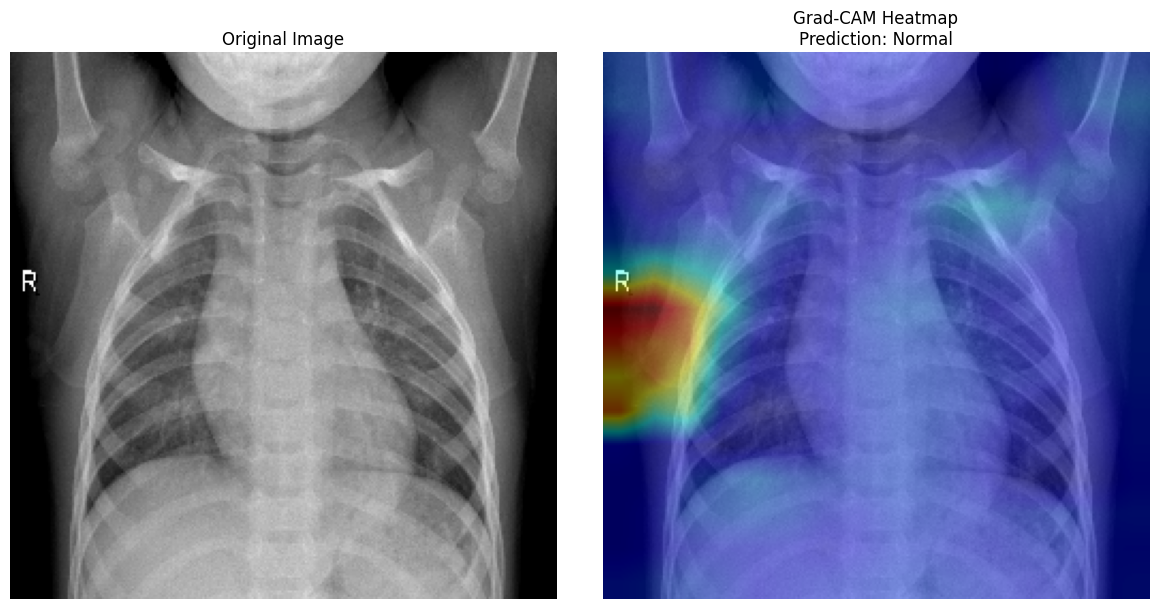

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.models import Model
from skimage.color import gray2rgb
from tensorflow.keras.preprocessing import image

# Define a function to process the image, apply Grad-CAM, and display results
def generate_grad_cam(image_path, model, class_labels=["Normal", "Pneumonia"], last_conv_layer_name="block5_conv3", target_size=(256, 256)):
    """
    Generate Grad-CAM heatmap for a given image.

    Parameters:
        image_path (str): Path to the image file.
        model (tf.keras.Model): Pretrained model.
        class_labels (list): List of class labels corresponding to the model's output classes.
        last_conv_layer_name (str): Name of the last convolutional layer for Grad-CAM.
        target_size (tuple): Resize image to this size before feeding to the model.
    """
    # Step 1: Load and preprocess the image
    img = image.load_img(image_path, target_size=target_size, color_mode='rgb')  # Load image
    img_array = image.img_to_array(img)  # Convert to array
    x = np.expand_dims(img_array, axis=0)  # Add batch dimension
    x = tf.cast(x, tf.float32)  # Ensure it's a float tensor

    # Step 2: Get predictions from the model
    preds = model(x)
    class_idx = tf.argmax(preds[0])  # Get the most likely predicted class
    predicted_class = class_labels[class_idx]  # Get the corresponding label for the predicted class

    # Step 3: Create a sub-model for Grad-CAM
    last_conv_layer = model.get_layer(last_conv_layer_name)  # Get the last convolutional layer
    grad_model = tf.keras.models.Model([model.inputs], [last_conv_layer.output, model.output])

    # Step 4: Record gradients using GradientTape
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(x)
        loss = predictions[:, class_idx]

    # Step 5: Compute gradients
    grads = tape.gradient(loss, conv_outputs)

    # Step 6: Compute the mean of the gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Step 7: Multiply each channel by its importance (gradient)
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Step 8: Normalize the heatmap
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    heatmap = heatmap.numpy()

    # Step 9: Resize heatmap to match the original image size
    heatmap_resized = cv2.resize(heatmap, (img_array.shape[1], img_array.shape[0]))
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)

    # Step 10: Overlay the heatmap on the original image
    superimposed_img = cv2.addWeighted(img_array.astype('uint8'), 0.6, heatmap_colored, 0.4, 0)

    # Step 11: Display the original image and Grad-CAM heatmap
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(img_array.astype('uint8'))
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(superimposed_img)
    plt.title(f"Grad-CAM Heatmap\nPrediction: {predicted_class}")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Example usage: Provide an image path and call the function
image_path = "/content/drive/MyDrive/Colab Notebooks/chest_xray/Normal/NORMAL-1031320-0001.jpeg"  # Change this to your image file path
generate_grad_cam(image_path, new_model)

In [ ]:
from keras.models import Sequential, load_model
from keras.layers import Flatten, Dense, Dropout

In [ ]:
model = keras.Sequential([
    # Convolutional layers
                   #kernels,  #filters ,  #activation function,          #input
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(256,256,3)),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(2, activation='sigmoid')

])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,839,234 (56.61 MB)

 Trainable params: 14,839,234 (56.61 MB)

 Non-trainable params: 0 (0.00 B)

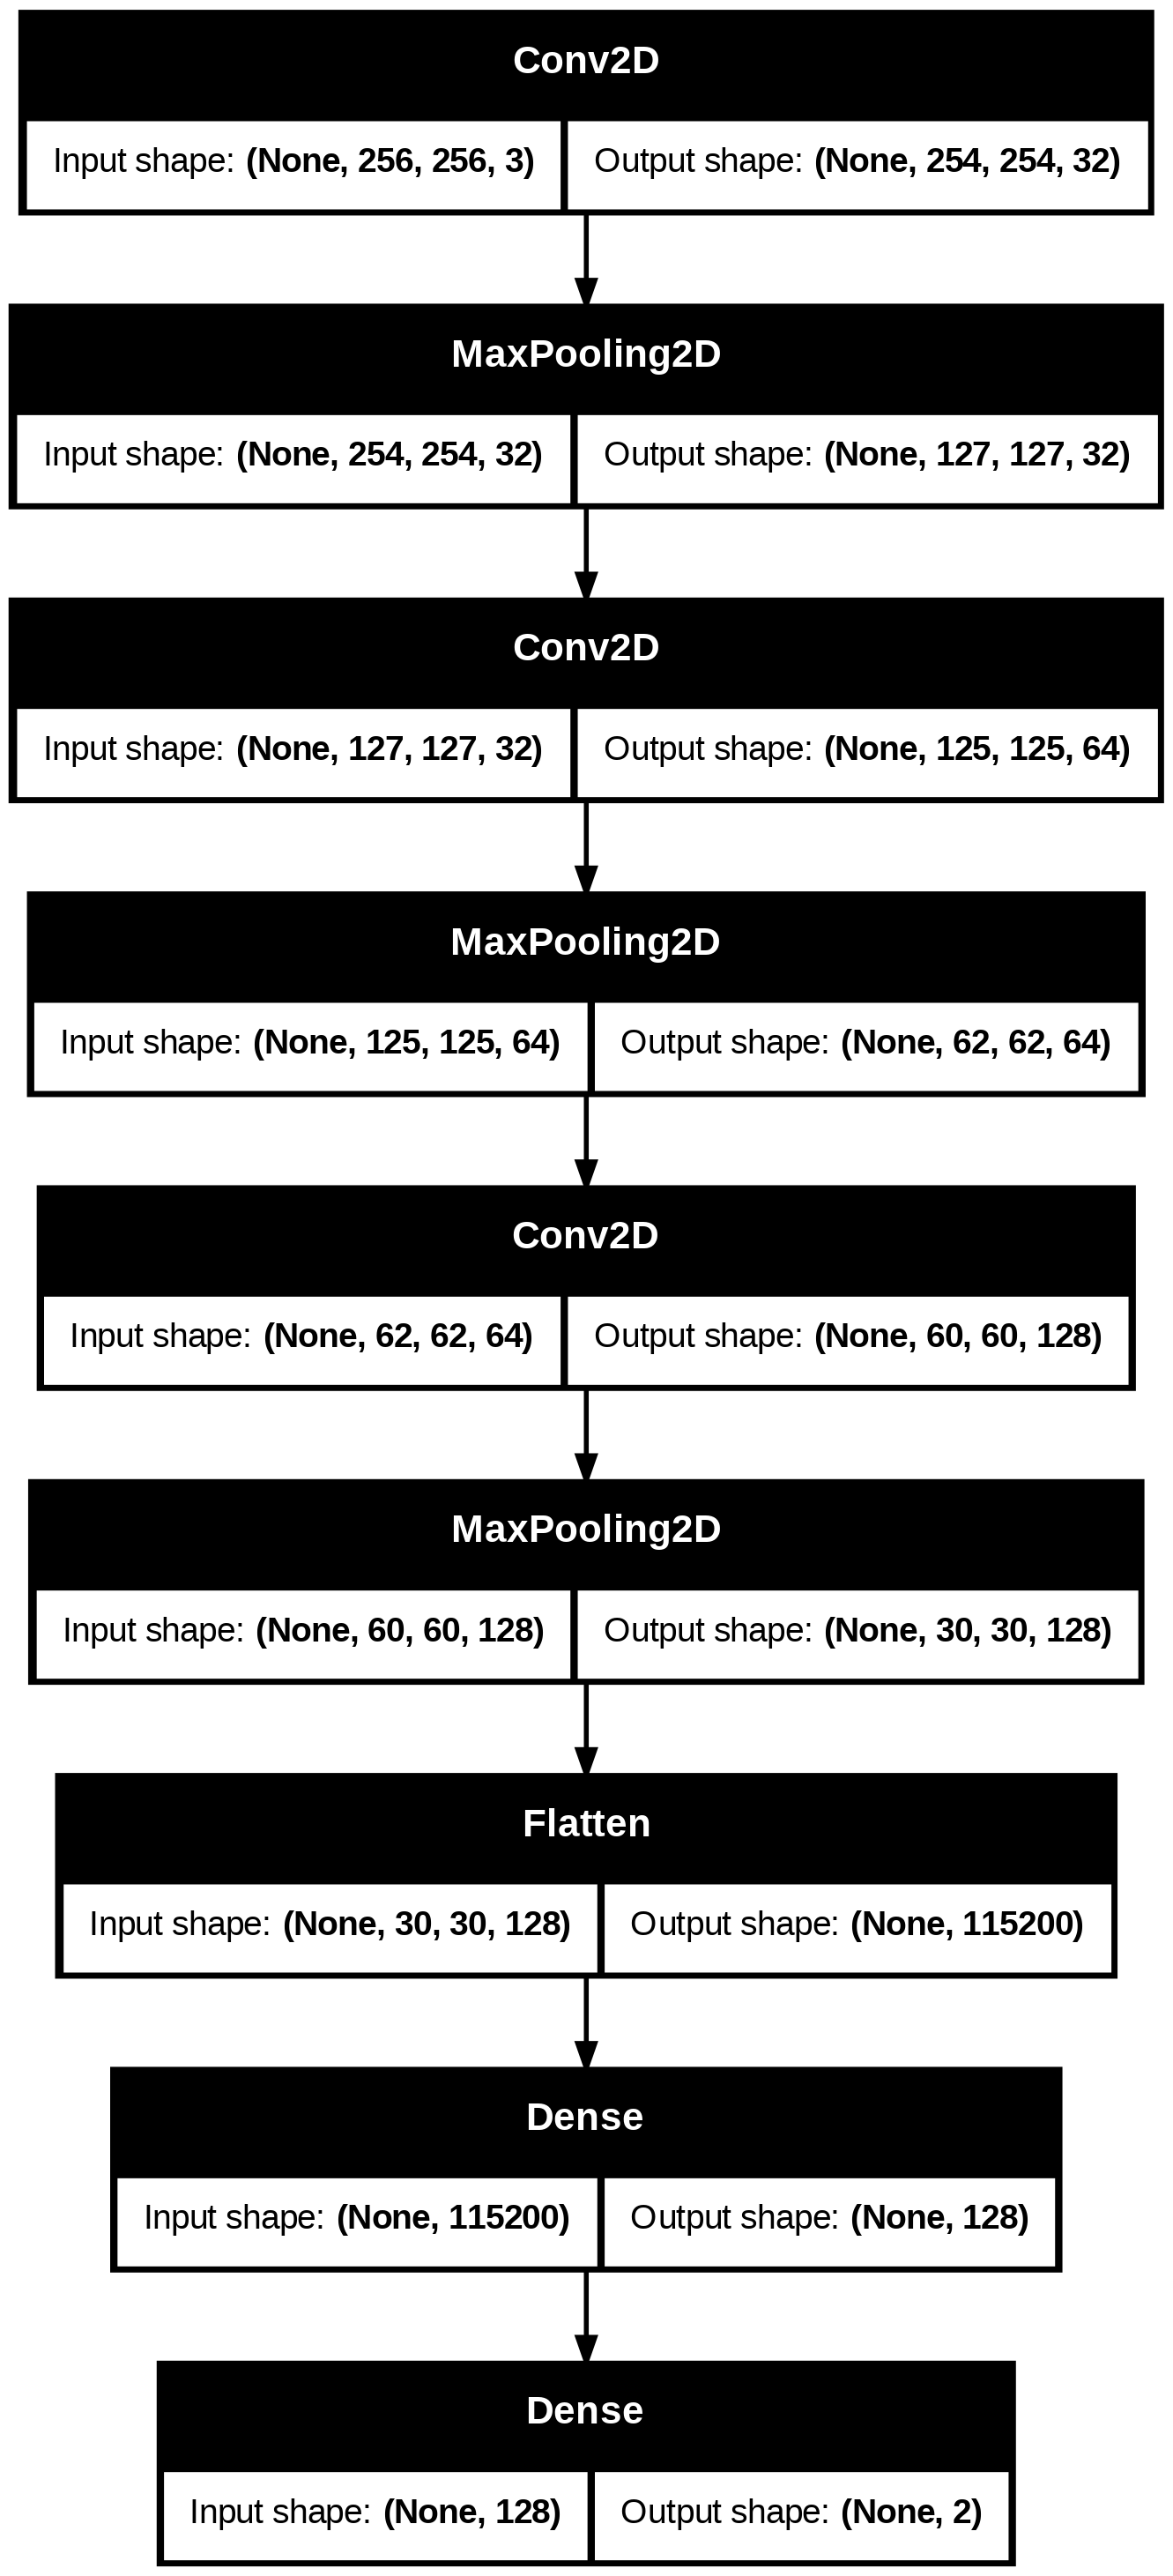

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes=True,to_file='binaryclass model.png')

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),

    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics=['accuracy']
)

NameError: name 'model' is not defined

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
callback = EarlyStopping(
    monitor = 'val_loss',
    min_delta = 0.00001,
    patience = 20,
    baseline = None,
    verbose = 1,
    mode = "auto",
    restore_best_weights = False
)

In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCH,
    callbacks=[callback]
)

Epoch 1/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 130s 461ms/step - accuracy: 0.6381 - loss: 19.1074 - val_accuracy: 0.7309 - val_loss: 0.6887
Epoch 2/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 115s 425ms/step - accuracy: 0.7148 - loss: 0.6877 - val_accuracy: 0.6979 - val_loss: 0.6845
Epoch 3/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 115s 427ms/step - accuracy: 0.7236 - loss: 0.6820 - val_accuracy: 0.7135 - val_loss: 0.6787
Epoch 4/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 144s 622ms/step - accuracy: 0.7348 - loss: 0.6758 - val_accuracy: 0.7517 - val_loss: 0.6701
Epoch 5/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 114s 427ms/step - accuracy: 0.7288 - loss: 0.6710 - val_accuracy: 0.7222 - val_loss: 0.6680


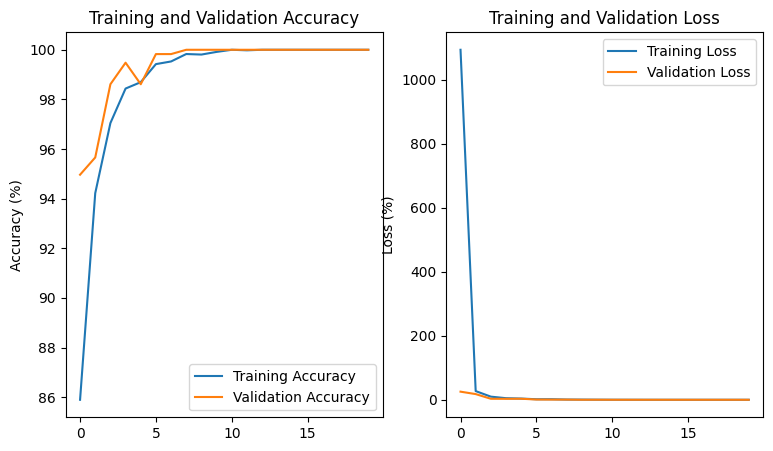

In [ ]:
plt.figure(figsize=(9, 5))

# Extract accuracy and loss from the history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# First Subplot: Accuracy (Scaled to 1-100)
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), [x * 100 for x in acc], label='Training Accuracy')  # Scale by 100
plt.plot(range(EPOCHS), [x * 100 for x in val_acc], label='Validation Accuracy')  # Scale by 100
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy (%)')  # Add ylabel to indicate percentage

# Second Subplot: Loss (Scaled to 1-100)
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), [x * 100 for x in loss], label='Training Loss')  # Scale by 100
plt.plot(range(EPOCHS), [x * 100 for x in val_loss], label='Validation Loss')  # Scale by 100
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel('Loss (%)')  # Add ylabel to indicate percentage

plt.show()